# PrettyScaler

### This python module uses input data to create a condensed isomorphic transformation $\mathcal{T}: \mathbf{R} \rightarrow \left(-1,1 \right) $

Do you usually use sklearn.preprocessing.StandardScaler to normalize your data? Sometimes, the distribution of the data can be so assymetric and heterogeneous that a better transformation is necessary. PrettyScaler acts in the same way as StandardScaler; fits a mapping from raw to normalized distributions. However, PrettyScaler will neatly condense the metric, squeezing all reals into the bound domain (-1,1) and producing a uniform density distribution.

Basically, it will map each $x \in \mathbf{R}$ to the cumulative function of the data. Since the training data is finite, PrettyScaler will add some wings to that cumulative function so that it is defined in the entire domain. 
The wing boundaries are defined by the wing_percentile argument, which represents the p-value enclosed by each of the 2 wings. These wings are exponential functions, and are glued to the main body by enforcing that the function value and gradient match and the boundary. Thus, this **makes the extrema of the data to be tucked into (-1,1), in an asymptotic fashion**.

The result of this transformation is a uniform distribution, but PrettyScaler can also output one that generates a bulge-like distribution. Depending on the "kind" argument in the fit() method, the probability density distributions will be:
* $\mathcal{P}_\mathrm{flat}(x)=1$
* $\mathcal{P}_\mathrm{bulge}(x)=1-\cos{\pi (x+1)}$

The mapping constructed by PrettyScaler meets the following requirements:
* $\mathcal{T}: \mathbf{R} \rightarrow \left(-1,1 \right) $
* $\mathcal{T}(x)\propto x$, monotonically increasing
* $\partial_x \mathcal{T}(x)$ is non-zero, finite and positive everywhere

When to use PrettyScaler:
* The main use case is to preprocess data for neural nets and SVMs
* It is not helpful for CART-based methods (decision trees, random forest, GBM), although it will not hurt either
* It will completely wash out 1-D clustering signal, so don't use it for this purpose


## Usage example

In [67]:
# Make some basic imports
import matplotlib.pyplot as plt;
%matplotlib inline
import numpy as np;
import prettyscaler;
from sklearn.preprocessing import StandardScaler;

In [3]:
# let's create some ugly mock data. This will be a mixture
# of a few truncated log-normal distributions:
def create_lognormal_truncated_sample(logmu,logsig,N,sign):
    random_sample = np.random.normal(logmu,logsig,size=N)
    random_sample = random_sample[sign*random_sample>sign*logmu]
    return 10**random_sample

random_sample1 = create_lognormal_truncated_sample(1,1,5000,-1)
random_sample2 = create_lognormal_truncated_sample(5,.3,5000,1)
random_sample3 = create_lognormal_truncated_sample(8,.25,5000,-1)
# Assemble the full data set:
my_data = np.r_[random_sample1,random_sample2, random_sample3]

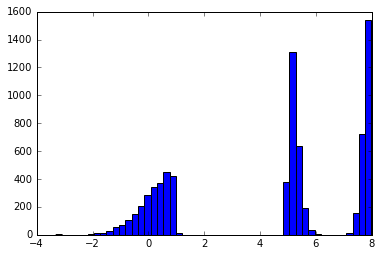

In [4]:
# Take a look at the monster we've created in a log plot
plt.hist(np.log10(my_data[my_data>0]),bins=50);

In [16]:
# Break the random sample into train and test sets:
np.random.shuffle(my_data)
test_data, train_data = my_data[::2], my_data[1::2]

In [17]:
# Initialize
pts = prettyscaler.PrettyScaler()
# Fit the data. The most important argument you need
# to care about is the wing_percentile. Roughly,
# set it to the fraction of your data that you would 
# consider quasi-outliers. For example, wing_percentile=0.01 
# will result in fitting the data directly with 98% of the points,
# and a 1% on each side is discarded (the reason for a non-zero 
# wing_percentile is that we need a robust computation of the gradient
# at the wing boundary, and there needs to be enough data density). 
# The argument sample_size determines the size of the grid
# that will be used to map the distribution densities. As a rule
# of thumb, try to have wing_percentile*sample_size > 10. If sample_size
# happens to be larger that the size of the training data, it will revert
# to the latter.
# Finally, ftol is the kind of the minimum difference enforced between
# consecutive values in the cumulative density array. It is there to make sure
# that the gradient of that array not close to being (numerically) flat anywhere.
#
# This might be a lot to take, but for most cases you can just
# use the default values and not worry about it.
#
# So, let's fit some data:
pts.fit(test_data, wing_percentile=0.01,ftol=1e-5,sample_size=1e3)
# If you want to load these params later, you should save
# them now to file:
pts.save_pickle('fitted_params.pkl')
# To load this state from scratch, you would just have to do:
# pts = prettydata.PrettyData()
# pts.load_pickle('fitted_params.pkl')

### PrettyScaler fits a mapping function. Here is what that function looks like.

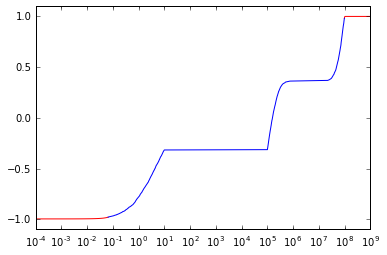

In [51]:
# Let us plot the input vs output spaces of the function. 
# We will highlight the different regions (wings and trunk)
# separately, and examine how well they blend together.
#
# First, gotta create an x-grid for the inputs. For
# better clarity, we'll make it logarithmically spaced:
right_wing_x = 10**np.linspace(np.log10(pts.all_params['rightwing_boundary_value']),np.log10(1e9),100)
left_wing_x = 10**np.linspace(np.log10(1e-4),np.log10(pts.all_params['leftwing_boundary_value']),100)
# This one we can fetch directly from the instance:
trunk_x = pts.all_params['trunk_x']

# Now, compute the outputs
right_wing_y = np.array([pts.transfer_function(u) for u in right_wing_x])
left_wing_y = np.array([pts.transfer_function(u) for u in left_wing_x])
trunk_y = np.array([pts.transfer_function(u) for u in trunk_x])

# Plot the whole thing. The wings are shown in red. 
# As mentioned earlier, the trunk (blue part) represents
# an interpolation to the cumulative function of the data. 
# The wings are not a direct fit to the data; they are 
# asymptotically declining functions that match the value
# and gradient of the trunk at the boundaries.
plt.plot(left_wing_x, left_wing_y, color='r')
plt.plot(right_wing_x, right_wing_y, color='r')
plt.plot(trunk_x, trunk_y, color='b')
plt.ylim(-1.1,1.1)
plt.xscale('log')
plt.yscale('linear')

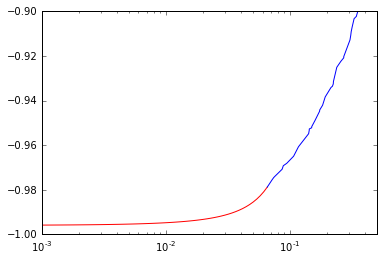

In [47]:
# Zoom into the left wing blend, it's pretty smooth:
plt.plot(left_wing_x, left_wing_y, color='r')
plt.plot(trunk_x, trunk_y, color='b')
plt.xlim(1e-3,5e-1)
plt.ylim(-1,-0.9)
plt.xscale('log')

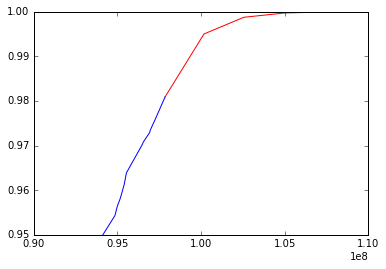

In [45]:
# Zoom into the right wing. Also smooth blend.
plt.plot(right_wing_x, right_wing_y, color='r')
plt.plot(trunk_x, trunk_y, color='b')
plt.xlim(9e7,1.1e8)
plt.ylim(0.95,1)
plt.xscale('linear')

In [66]:
# In addition, the gradient should be positive everywhere. 
# Assemble full output grid:
test_ygrid = np.r_[left_wing_y, trunk_y, right_wing_y]

# Check that there is no negative gradient:
assert(min(np.gradient(test_ygrid))>=0)

# In the trunk specifically, check that the
# gradient is larger than zero everywhere:
assert(min(np.gradient(trunk_y))>0)

In [28]:
# Transform the test data into a flat and bulge spaces:
test_data_flat = pts.transform(test_data, kind='flat')
test_data_bulge = pts.transform(test_data, kind='bulge')

Mapping to bulge distribution


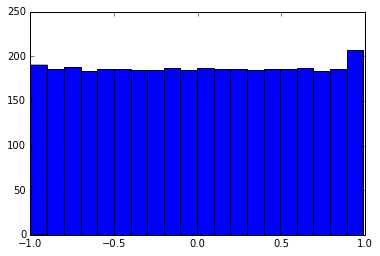

In [29]:
# Plot the histogram of the flat representation
plt.hist(test_data_flat, bins=20);

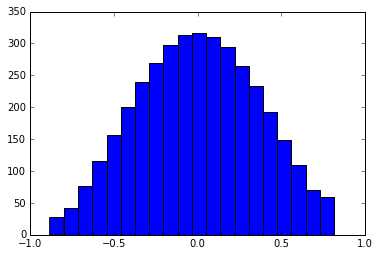

In [30]:
# And a histogram of the bulge representation
plt.hist(test_data_bulge, bins=20);